In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def diff_fn(X, Y):
    """
    X: m x N
    Y: m x N
    """
    
    X = np.expand_dims(X, axis=1) # m x 1 x N
    Y = np.expand_dims(Y, axis=0) # 1 x m x N
    diff = X - Y # m x m x N
    return diff

In [3]:
def diff_norm_sq_fn(X, Y):
    """
    X: m x N
    Y: m x N
    """
    
    diff = diff_fn(X, Y) # m x m x N
    diff_norm_sq = np.sum(diff**2, axis=-1) # m x m
    return diff_norm_sq

In [4]:
def kernel_function(X, h):
    """
    Args:
        X: m x N
        h: float
    """

    m, N = X.shape

    diff_norm_sq = diff_norm_sq_fn(X, X) # m x m
    kernelMatrix = np.exp(- 1 / (2 * h**2) * diff_norm_sq) # m x m

    kernelMatrix_expand  = np.expand_dims(kernelMatrix, axis=-1) # m x m x 1
    diff = diff_fn(X, X) # m x m x N
    gradKernel1 = - 1 / (h**2) * diff * kernelMatrix_expand # m x m x N
    gradKernel2 = - gradKernel1 # m x m x N

    hessKernel = (N - (1 / h **2) * diff_norm_sq) * kernelMatrix / h ** 2
    
    return kernelMatrix, gradKernel1, gradKernel2, hessKernel

In [5]:
def UqMatrix(X, h):
    
    kernelMatrix, gradKernel1, gradKernel2, hessKernel = kernel_function(X, h)
    X_expand = np.expand_dims(-X, axis = 1) # m x 1 x N
    Y_expand = np.expand_dims(-X, axis = 0) # 1 x m x N
    UMatrix = kernelMatrix * np.dot(X, X.T) + np.sum(X_expand * gradKernel2, axis = -1) + np.sum(Y_expand * gradKernel1, axis = -1) + hessKernel

    return UMatrix

In [6]:
def KSD(X, U):

    m, _ = X.shape
    matDiag = np.sum(U.diagonal())
    matSum = U.sum()
    KSD = (matSum - matDiag) / (m * (m - 1))
    
    return KSD

In [7]:
def Bootstrap_KSD(U, size = 1000, epochshow = False):
    """
    
    """

    m, _ = U.shape
    multi_prob = np.repeat((1 / m), m)

    Sstar = np.zeros(size)
    for i in range(size):
        Weight = np.random.multinomial(m, multi_prob)
        Wadjust = (Weight - 1) / m
        WMatrix = np.outer(Wadjust, Wadjust)
        SMatrix = WMatrix * U
        diag_sum = sum(SMatrix.diagonal())
        matrix_sum = SMatrix.sum()
        Si = matrix_sum - diag_sum
        Sstar[i] = Si
        if epochshow != False:
            if (i+1) % epochshow == 0:
                print(f"we are in epoch {i+1}")

    return Sstar

In [8]:
def approx_pvalue(S, Sstar):
    """
    param S: unbiased estimation of KSD, scalar
    param Sstar: unbiased m bootstrap sample KSD
    """
    n = len(Sstar)
    TFarray = Sstar[Sstar >= S]
    count = len(TFarray)
    return count / n

In [9]:
def pValue_meanshift(samplesize, dim, bandwidth, meanvalue, bootstrapsize = 1000, iter = 100):
    """
    param stepvalue: 1D numpy array with dimension dim or boolean value False
    param covalue: 1D numpy array with dimension dim or boolean value False

    param
    """
    n = len(meanvalue)
    pvalue = np.zeros((n, iter))
    cov = np.identity(dim)
    for i in range(n):
        mi = meanvalue[i]
        mean = np.repeat(mi, dim)
        for j in range(iter):
            Multinormal_X = np.random.multivariate_normal(mean, cov, samplesize)
            UMatrix = UqMatrix(Multinormal_X, bandwidth)
            KSDvalue = KSD(Multinormal_X, UMatrix)
            KSDstar = Bootstrap_KSD(UMatrix, size = bootstrapsize, epochshow = False)
            pvalue[i, j] = approx_pvalue(KSDvalue, KSDstar)
        
        print(f"the {i + 1}th mean finished !")
    return pvalue

In [10]:
def pValue_varshift(samplesize, dim, bandwidth, varvalue, bootstrapsize = 1000, iter = 100):
    """
    param stepvalue: 1D numpy array with dimension dim or boolean value False
    param covalue: 1D numpy array with dimension dim or boolean value False

    param
    """
    n = len(varvalue)
    pvalue = np.zeros((n, iter))
    mean = np.zeros(dim)
    for i in range(n):
        vi = varvalue[i]
        cov = np.identity(dim) * vi
        for j in range(iter):
            Multinormal_X = np.random.multivariate_normal(mean, cov, samplesize)
            UMatrix = UqMatrix(Multinormal_X, bandwidth)
            KSDvalue = KSD(Multinormal_X, UMatrix)
            KSDstar = Bootstrap_KSD(UMatrix, size = bootstrapsize)
            pvalue[i, j] = approx_pvalue(KSDvalue, KSDstar)
    return pvalue

In [11]:
zeromean = np.array([0])

In [ ]:
dim20_sieze100 = pValue_meanshift(100, 20, 1, meanvalue=zeromean, iter = 300)

In [ ]:
dim20_sieze300 = pValue_meanshift(300, 20, 1, meanvalue=zeromean, iter = 300)

In [ ]:
dim20_sieze500 = pValue_meanshift(500, 20, 1, meanvalue=zeromean, iter = 300)

In [ ]:
dim20_sieze1000 = pValue_meanshift(1000, 20, 1, meanvalue=zeromean, iter = 300)

In [ ]:
data_20 = np.array([dim20_sieze100[0], dim20_sieze300[0], dim20_sieze500[0], dim20_sieze1000[0]])

In [ ]:
fig = plt.figure(figsize =(12, 6))
fig.suptitle("p value agains change of sample size, dimension = 20", fontsize = 16)

ax = fig.add_subplot(111)

ax.boxplot(data_20.T)
ax.axhline(0.25)
ax.axhline(0.5)
ax.axhline(0.75)
ax.set_xticklabels(["100", "300", "500", "1000"])
ax.set_xlabel("sample size")
ax.set_ylabel("p value")

plt.show()

In [ ]:
dim50_sieze100 = pValue_meanshift(100, 50, 1, meanvalue=zeromean, iter = 300)

In [ ]:
dim50_sieze300 = pValue_meanshift(300, 50, 1, meanvalue=zeromean, iter = 300)

In [ ]:
dim50_sieze500 = pValue_meanshift(500, 50, 1, meanvalue=zeromean, iter = 300)

In [ ]:
dim50_sieze1000 = pValue_meanshift(1000, 50, 1, meanvalue=zeromean, iter = 300)

In [ ]:
dim50_sieze2000 = pValue_meanshift(2000, 50, 1, meanvalue=zeromean, iter = 300)

In [ ]:
data_50 = np.array([dim50_sieze100[0], dim50_sieze300[0], dim50_sieze500[0], dim50_sieze1000[0], dim50_sieze2000[0]])

In [ ]:
fig = plt.figure(figsize =(12, 6))
fig.suptitle("p value agains change of sample size, dimension = 50", fontsize = 16)

ax = fig.add_subplot(111)

ax.boxplot(data_50.T)
ax.axhline(0.25)
ax.axhline(0.5)
ax.axhline(0.75)
ax.set_xticklabels(["100", "300", "500", "1000", "2000"])
ax.set_xlabel("sample size")
ax.set_ylabel("p value")

plt.show()

In [ ]:
meanarray = np.linspace(0, 0.9, 4)

p_meanshift_20D = pValue_meanshift(1000, 20, 1, meanvalue=meanarray, iter = 100)

In [ ]:
fig = plt.figure(figsize =(12, 6))
fig.suptitle("p value against mean shift, dimension = 20", fontsize = 16)

ax = fig.add_subplot(121)
ax.boxplot(p_meanshift_20D.T)
ax.set_xticklabels([0, 0.3, 0.6, 0.9])
ax.set_xlabel("mean value")
ax.set_ylabel("p value")

ax1 = fig.add_subplot(122)
ax1.boxplot(p_meanshift_20D.T)
ax1.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xlabel("mean value")
ax1.set_ylabel("p value")
ax1.set_ylim(0, 0.5)
 
# show plot
plt.show()

In [26]:
mean_shift_1 = np.array([0.01])

p_bdw1_1D = pValue_meanshift(1000, 1, 1, meanvalue=mean_shift_1, iter = 100)[0]

the 1th mean finished !


In [27]:
p_bdw2_1D = pValue_meanshift(1000, 1, 2, meanvalue=mean_shift_1, iter = 100)[0]

the 1th mean finished !


In [28]:
p_bdw5_1D = pValue_meanshift(1000, 1, 5, meanvalue=mean_shift_1, iter = 100)[0]

the 1th mean finished !


In [29]:
p_bdw10_1D = pValue_meanshift(1000, 1, 10, meanvalue=mean_shift_1, iter = 100)[0]

the 1th mean finished !


In [30]:
data_bdw_1D = np.array([p_bdw1_1D, p_bdw2_1D, p_bdw5_1D, p_bdw10_1D])

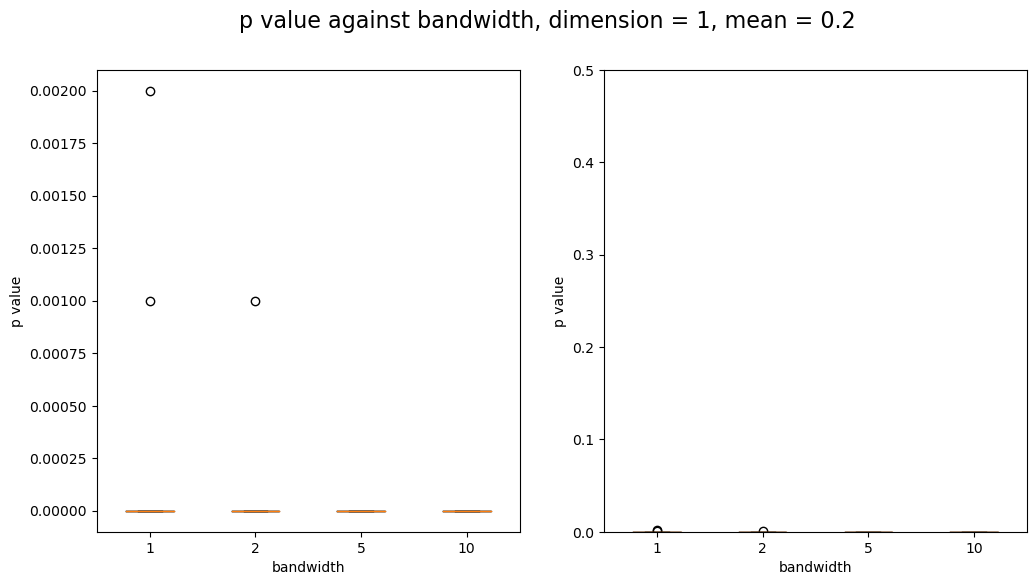

In [32]:
fig = plt.figure(figsize =(12, 6))
fig.suptitle("p value against bandwidth, dimension = 1, mean = 0.2", fontsize = 16)

ax = fig.add_subplot(121)
ax.boxplot(data_bdw_1D.T)
ax.set_xticklabels(["1", "2", "5", "10"])
ax.set_xlabel("bandwidth")
ax.set_ylabel("p value")

ax1 = fig.add_subplot(122)
ax1.boxplot(data_bdw_1D.T)
ax1.set_xticklabels(["1", "2", "5", "10"])
ax1.set_xlabel("bandwidth")
ax1.set_ylabel("p value")
ax1.set_ylim(0, 0.5)
 
# show plot
plt.show()

In [ ]:
p_bdw1_5D = pValue_meanshift(1000, 5, 1, meanvalue=mean_shift_1, iter = 100)[0]

In [ ]:
p_bdw2_5D = pValue_meanshift(1000, 5, 2, meanvalue=mean_shift_1, iter = 100)[0]

In [ ]:
p_bdw5_5D = pValue_meanshift(1000, 5, 5, meanvalue=mean_shift_1, iter = 100)[0]

In [ ]:
p_bdw10_5D = pValue_meanshift(1000, 5, 10, meanvalue=mean_shift_1, iter = 100)[0]

In [ ]:
data_bdw_5D = np.array([p_bdw1_5D, p_bdw2_5D, p_bdw5_5D, p_bdw10_5D])

In [ ]:
fig = plt.figure(figsize =(12, 6))
fig.suptitle("p value against bandwidth, dimension = 5, mean = 0.2", fontsize = 16)

ax = fig.add_subplot(121)
ax.boxplot(data_bdw_5D.T)
ax.set_xticklabels(["1, 2, 5, 10"])
ax.set_xlabel("bandwidth")
ax.set_ylabel("p value")

ax1 = fig.add_subplot(122)
ax1.boxplot(data_bdw_5D.T)
ax1.set_xticklabels(["1, 2, 5, 10"])
ax1.set_xlabel("bandwidth")
ax1.set_ylabel("p value")
ax1.set_ylim(0, 0.5)
 
# show plot
plt.show()

In [ ]:
vararray = np.linspace(1, 2, 3)

p_varshift_20D = pValue_varshift(1000, 20, 1, varvalue=vararray, iter = 100)

In [ ]:
fig = plt.figure(figsize =(12, 6))
fig.suptitle("p value against variance shift, dimension = 20", fontsize = 16)

ax = fig.add_subplot(111)
ax.boxplot(p_varshift_20D.T)
ax.set_xticklabels([1, 1.5, 2])
ax.set_xlabel("variance value")
ax.set_ylabel("p value")

plt.show()

In [16]:
mean_shift_2 = np.array([0.3])

p_meanshift2_1D = pValue_meanshift(100, 1, 1, meanvalue=mean_shift_2, iter=100)[0]
p_meanshift2_5D = pValue_meanshift(100, 5, 1, meanvalue=mean_shift_2, iter=100)[0]
p_meanshift2_10D = pValue_meanshift(100, 10, 1, meanvalue=mean_shift_2, iter=100)[0]
p_meanshift2_20D = pValue_meanshift(100, 20, 1, meanvalue=mean_shift_2, iter=100)[0]
p_meanshift2_50D = pValue_meanshift(100, 50, 1, meanvalue=mean_shift_2, iter=100)[0]

the 1th mean finished !
the 1th mean finished !
the 1th mean finished !
the 1th mean finished !
the 1th mean finished !


In [19]:
data_meanshift2 = np.array([p_meanshift2_1D, p_meanshift2_5D, p_meanshift2_10D, p_meanshift2_20D, p_meanshift2_50D])

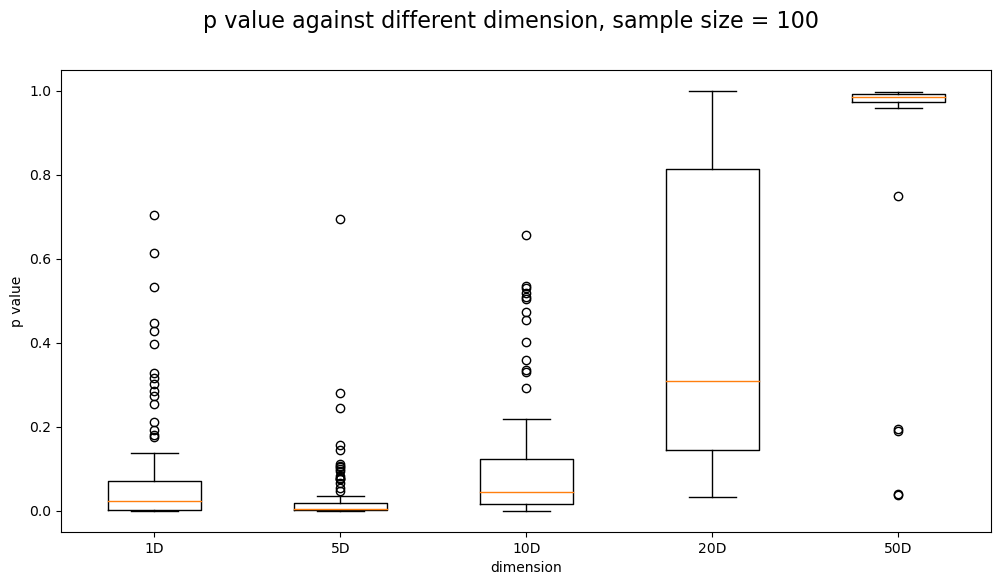

In [20]:
fig = plt.figure(figsize =(12, 6))
fig.suptitle("p value against different dimension, sample size = 100", fontsize = 16)

ax = fig.add_subplot(111)
ax.boxplot(data_meanshift2.T)
ax.set_xticklabels(["1D", "5D", "10D", "20D", "50D"])
ax.set_xlabel("dimension")
ax.set_ylabel("p value")

plt.show()

In [21]:
p_meanshift1_1D = pValue_meanshift(100, 1, 1, meanvalue=mean_shift_2, iter=100)[0]

the 1th mean finished !


In [22]:
p_meanshift1_5D = pValue_meanshift(300, 5, 1, meanvalue=mean_shift_2, iter=100)[0]

the 1th mean finished !


In [23]:
p_meanshift1_10D = pValue_meanshift(500, 10, 1, meanvalue=mean_shift_2, iter=100)[0]

the 1th mean finished !


In [24]:
p_meanshift1_20D = pValue_meanshift(1000, 20, 1, meanvalue=mean_shift_2, iter=100)[0]

the 1th mean finished !


In [ ]:
p_meanshift1_50D = pValue_meanshift(2000, 50, 1, meanvalue=mean_shift_2, iter=100)[0]

KeyboardInterrupt: 

In [ ]:
data_meanshift1 = np.array([p_meanshift1_1D, p_meanshift1_5D, p_meanshift1_10D, p_meanshift1_20D, p_meanshift1_50D])

In [ ]:
# Just for entertaining

fig = plt.figure(figsize =(12, 6))
fig.suptitle("p value against different dimension and sample size", fontsize = 16)

ax = fig.add_subplot(111)
ax.boxplot(data_meanshift2.T)
ax.set_xticklabels(["1D,s=100", "5D,s=300", "10D,s=500", "20D,s=1000", "50D,s=2000"])
ax.set_xlabel("dimension")
ax.set_ylabel("p value")

plt.show()